In [ ]:
%matplotlib inline
#!/usr/bin/python
#from __future__ import unicode_literals""""""

In [ ]:
import numpy as np
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt
from copy import deepcopy
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from gensim.summarization import bm25
import nltk
import numpy as np
import random
import pickle
import scipy
import sklearn
import tqdm

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
#from keras.preprocessing import sequence
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Activation,concatenate,Embedding,LSTM,Conv1D,MaxPooling1D,Flatten,Input,Bidirectional,LSTM,Concatenate,TimeDistributed
from tensorflow.keras.layers import Subtract,Lambda,Add,Conv1D,Dot
#from tensorflow.keras.utils.vis_utils import model_to_dot	
from tensorflow.keras.utils import plot_model,to_categorical
from IPython.display import SVG
#SVG(model_to_dot(model).create(prog='dot', format='svg'))


## load embedding model

In [ ]:
"""
PATH="/media/anvesh/Garden of EDEN/Academics/embedding_models/eng/"
from gensim.models import KeyedVectors
embedding_model=KeyedVectors.load_word2vec_format(PATH + "wiki-news-300d-1M.vec")
embedding_model=pickle.load(open("mrfasttext.pickle","rb"))
"""

'\nPATH="/media/anvesh/Garden of EDEN/Academics/embedding_models/eng/"\n\n\nfrom gensim.models import KeyedVectors\nembedding_model=KeyedVectors.load_word2vec_format(PATH + "wiki-news-300d-1M.vec")\n\n\nembedding_model=pickle.load(open("mrfasttext.pickle","rb"))\n'

In [ ]:
!wget https://nlp.stanford.edu/data/glove.840B.300d.zip
from zipfile import ZipFile
with ZipFile('glove.840B.300d.zip','r') as f:
  f.extractall()
  
!rm -rf glove.840B.300d.zip

embedding_index = {}
with open('glove.840B.300d.txt','r',encoding='utf-8') as f1:
  for line in f1.readlines():
    words = line.split(' ')
    word = words[0]
    embedding_vec = np.asarray(words[1:],dtype='float32')
    embedding_index[word] = embedding_vec

## Load SST

In [ ]:
#from google.colab import files
#files.upload()

In [ ]:
!wget https://github.com/harvardnlp/sent-conv-torch/raw/master/data/stsa.fine.dev
!wget https://raw.githubusercontent.com/harvardnlp/sent-conv-torch/master/data/stsa.fine.phrases.train
!wget https://github.com/harvardnlp/sent-conv-torch/raw/master/data/stsa.fine.train
!wget https://github.com/harvardnlp/sent-conv-torch/raw/master/data/stsa.fine.test

In [ ]:
DPATH="./"
train=open(DPATH+"stsa.fine.train","r",encoding="ISO-8859-1").readlines()
test=open(DPATH+"stsa.fine.test","r",encoding="ISO-8859-1").readlines()
dev=open(DPATH+"stsa.fine.dev","r",encoding="ISO-8859-1").readlines()
phras=open(DPATH+"stsa.fine.phrases.train","r",encoding="ISO-8859-1").readlines()
train=[[int(i[0]),re.split(r'\d\s',i)[1].strip()] for i in train]
test=[[int(i[0]),re.split(r'\d\s',i)[1].strip()] for i in test]
dev=[[int(i[0]),re.split(r'\d\s',i)[1].strip()] for i in dev]
phras=[[int(i[0]),re.split(r'\d\s',i)[1].strip()] for i in phras]
trainlabels,traindata=list(zip(*train))
testlabels,testdata=list(zip(*test))
devlabels,devdata=list(zip(*dev))

In [ ]:
embedding_model=embedding_index

In [ ]:
Data=traindata

In [ ]:
print("Average sentence length is ",np.average([len(i.split(" ")) for i in Data]))
print("Maximum sentence length is ",max([len(i.split(" ")) for i in Data]))

#rain_test_split()

In [ ]:
Tx=50
d=300
c=len(set(trainlabels))
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(Data+devdata)
sequences = tokenizer.texts_to_sequences(Data)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=Tx)

print('Shape of Input:', data.shape)
#print('Shape of label tensor:', labels.shape)

#embedding_model
unknown=[]

embedding_matrix = np.zeros((len(word_index) + 1, d))
for word, i in word_index.items():
    if word not in embedding_model:
        unknown.append(word)
        embedding_matrix[i] = embedding_model["unk"]
    else:
        embedding_matrix[i] = embedding_model[word]
        
embedding_layer = Embedding(len(word_index) + 1,d,weights=[embedding_matrix],input_length=Tx,trainable=False)
#embedding_layer = Embedding(len(word_index) + 1,d,input_length=Tx,trainable=True)
print(len(unknown),len(set(unknown)))

Found 16005 unique tokens.
Shape of Input: (8544, 50)
474 474


## Making the Model

In [ ]:
X_train=pad_sequences(tokenizer.texts_to_sequences(traindata),maxlen=Tx)
X_test=pad_sequences(tokenizer.texts_to_sequences(testdata),maxlen=Tx)
X_dev=pad_sequences(tokenizer.texts_to_sequences(devdata),maxlen=Tx)
y_train=to_categorical(trainlabels,num_classes=c)
y_test=to_categorical(testlabels,num_classes=c)
y_dev=to_categorical(devlabels,num_classes=c)

In [ ]:
############ SHORTEN
X_train.shape,X_test.shape,X_dev.shape,y_train.shape,y_test.shape,y_dev.shape

((8544, 50), (2210, 50), (1101, 50), (8544, 5), (2210, 5), (1101, 5))

In [ ]:
def my_model_():
  In=Input(shape=(Tx,),name="Input_Sentence")
  o=embedding_layer(In)
  o=(LSTM(165,return_sequences=False))(o)
  o=Dense(c,activation="softmax")(o)
  model=Model(inputs=In,outputs=o)
  return model

def my_model_():
  In=Input(shape=(Tx,),name="Input_Sentence")
  o=embedding_layer(In)
  o1=(Conv1D(filters=50,kernel_size=5))(o)
  o1=(MaxPooling1D(Tx - 4))(o1)
  o1=Flatten()(o1)

  o2=(Conv1D(filters=50,kernel_size=4))(o)
  o2=(MaxPooling1D(Tx -3))(o2)
  o2=Flatten()(o2)
  
  o3=(Conv1D(filters=50,kernel_size=3))(o)
  o3=(MaxPooling1D(Tx - 2))(o3)
  o3=Flatten()(o3)
  
  o=Concatenate()([o1,o2,o3])
  o=Dense(c,activation="softmax")(o)
  model=Model(inputs=In,outputs=o)
  return model

def Attention2layer(units,lo):
  edense1=TimeDistributed(Dense(units,activation="tanh",use_bias=True),name="dense1")(lo)
  edense2=TimeDistributed(Dense(1,activation="linear",use_bias=True),name="dense2")(edense1)
  #temp=Reshape((20))(edense2)
  temp=Flatten()(edense2)
  print(temp.shape)
  alp=Activation("softmax")(temp)
  dot=Dot(axes=1)([alp,lo])
  return dot

def my_model():
  I=Input(shape=(Tx,),name="Input_Sentence")
  si=embedding_layer(I)
  lo=(LSTM(168,return_sequences=True))(si)
  ao=Attention2layer(10,lo)
  do=Dense(100,activation="relu")(ao)
  o=Dense(c,activation="softmax")(do)
  model=Model(inputs=I,outputs=o)
  return model

def fit_model(XX,yy,model,verbose=0,epochs=25):
  model.compile(loss="categorical_crossentropy",metrics=["acc"],optimizer="Adam")
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=10,restore_best_weights=True)
  history=model.fit(x=XX,y=yy,epochs=epochs,batch_size=130,validation_data=[X_dev,y_dev],callbacks=[es],verbose=verbose)
  return model

def indexer(test_list,index_list,nparr=True):
  if nparr==True:
    return np.array([test_list[i] for i in index_list])
  else:
    return [test_list[i] for i in index_list]

model=my_model()
model.summary()
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

(None, 50)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Sentence (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 300)      4801800     Input_Sentence[0][0]             
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 50, 165)      307560      embedding[0][0]                  
__________________________________________________________________________________________________
dense1 (TimeDistributed)        (None, 50, 10)       1660        lstm[0][0]                       
_________________________________________________________________________________

## Non Curriculum

In [ ]:
model.compile(loss="categorical_crossentropy",metrics=["acc"],optimizer="Adam")
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10,restore_best_weights=True)
history=model.fit(x=X_train,y=y_train,epochs=30,batch_size=120,validation_data=[X_dev,y_dev],callbacks=[es])

In [ ]:
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])

In [ ]:
model.evaluate(X_dev,y_dev,verbose=0)[1],model.evaluate(X_test,y_test,verbose=0)[1],model.evaluate(X_train,y_train,verbose=0)[1]

Multiple Runs

In [ ]:
ncc=[]
for i in np.arange(10):
  model=my_model()
  model=fit_model(X_train,y_train,model,verbose=0,epochs=30)
  ncc.append(model.evaluate(X_test,y_test)[1])
NC=np.mean(ncc)

(None, 50)
70/70 [==============================] - 0s 7ms/step - loss: 1.3375 - acc: 0.4181
(None, 50)
70/70 [==============================] - 0s 7ms/step - loss: 1.3290 - acc: 0.4195
(None, 50)
70/70 [==============================] - 0s 7ms/step - loss: 1.3408 - acc: 0.4140
(None, 50)
70/70 [==============================] - 0s 7ms/step - loss: 1.3767 - acc: 0.4063
(None, 50)
70/70 [==============================] - 0s 7ms/step - loss: 1.3504 - acc: 0.4136
(None, 50)
70/70 [==============================] - 0s 7ms/step - loss: 1.3437 - acc: 0.4090
(None, 50)
70/70 [==============================] - 0s 7ms/step - loss: 1.3483 - acc: 0.4140
(None, 50)
70/70 [==============================] - 0s 7ms/step - loss: 1.3355 - acc: 0.4199
(None, 50)
70/70 [==============================] - 0s 7ms/step - loss: 1.3160 - acc: 0.4357
(None, 50)
70/70 [==============================] - 0s 7ms/step - loss: 1.3209 - acc: 0.4167


In [ ]:
ncc, NC

([0.4180995523929596,
  0.41945701837539673,
  0.4140271544456482,
  0.40633484721183777,
  0.4135746657848358,
  0.40904977917671204,
  0.4140271544456482,
  0.4199095070362091,
  0.43574661016464233,
  0.41674208641052246],
 0.4166968375444412)

## Aux Task Sentiwordnet

In [ ]:
import nltk
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.corpus import sentiwordnet as swn

[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import itertools
vocab = list(set(list(itertools.chain.from_iterable([i.split() for i in traindata]))))
def score_d(word):
 # print(word)
  k = [(i.pos_score(),i.neg_score(),i.obj_score()) for i in list(swn.senti_synsets(word))]
  try:
    maxpos = max(list(zip(*k))[0])
    maxneg = max(list(zip(*k))[1])
    return maxpos + maxneg
  except:
    return 0

In [ ]:
d = [score_d(i) for i in vocab]

In [ ]:
sorted_vocab = [x for _,x in sorted(zip(d,vocab),reverse=True)]
sorted_vocab[:10],sorted(d,reverse=True)[:10]

(['soft',
  'pretty',
  'prettiest',
  'meanest',
  'mean',
  'bully',
  'awful',
  'worse',
  'sweetest',
  'sweet'],
 [1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.625, 1.625, 1.625])

In [ ]:
word="awful"
[(i.synset).definition() for i in list(swn.senti_synsets(word))]

['exceptionally bad or displeasing',
 'causing fear or dread or terror',
 'offensive or even (of persons) malicious',
 'inspired by a feeling of fearful wonderment or reverence',
 'extreme in degree or extent or amount or impact',
 'inspiring awe or admiration or wonder',
 'used as intensifiers']

In [ ]:
[(i.pos_score(),i.neg_score(),i.obj_score()) for i in list(swn.senti_synsets(word))]

[(0.0, 0.875, 0.125),
 (0.0, 0.625, 0.375),
 (0.0, 0.875, 0.125),
 (0.5, 0.5, 0.0),
 (0.125, 0.25, 0.625),
 (0.875, 0.125, 0.0),
 (0.25, 0.0, 0.75)]

In [ ]:
[(i.synset).examples() for i in list(swn.senti_synsets(word))]

[['atrocious taste',
  'abominable workmanship',
  'an awful voice',
  'dreadful manners',
  'a painful performance',
  'terrible handwriting',
  'an unspeakable odor came sweeping into the room'],
 ['the awful war',
  'an awful risk',
  'dire news',
  'a career or vengeance so direful that London was shocked',
  'the dread presence of the headmaster',
  'polio is no longer the dreaded disease it once was',
  'a dreadful storm',
  'a fearful howling',
  'horrendous explosions shook the city',
  'a terrible curse'],
 ['in a nasty mood',
  'a nasty accident',
  'a nasty shock',
  'a nasty smell',
  'a nasty trick to pull',
  'Will he say nasty things at my funeral?"- Ezra Pound'],
 ['awed by the silence', 'awful worshippers with bowed heads'],
 ['in a frightful hurry', 'spent a frightful amount of money'],
 ['New York is an amazing city',
  'the Grand Canyon is an awe-inspiring sight',
  'the awesome complexity of the universe',
  'this sea, whose gently awful stirrings seem to speak of 

In [ ]:
[i for i in list(swn.senti_synsets(word))]

[SentiSynset('pretty.s.01'),
 SentiSynset('pretty.s.02'),
 SentiSynset('reasonably.r.01')]

In [ ]:
def score(word):
  l=list(swn.senti_synsets(word))
  if len(l)==0:
    return False
    #return 0,0,0
  pos=[]
  neg=[]
  obj=[]
  for i in l:
    if i.pos_score()!=0.0 or i.neg_score()!=0.0:      
      pos.append(i.pos_score())
      neg.append(i.neg_score())
      obj.append(i.obj_score())
  #print(pos,neg)
  if len(pos)==0:#means neg is also 0:
    return False
    #return 0,0,0
  return(np.mean(pos),np.mean(neg),np.mean(obj))

def feature(sentence):
  words=sentence.split(" ")
  l=len(words)
  pos=0
  neg=0
  obj=0
  for i in words:
    if score(i)!=False:
      p,n,o=score(i)
      #print(p,n,i)
      pos=pos+p
      neg=neg+n
      obj=obj+o
  return np.array([l,pos,neg,obj,np.abs(pos-neg),pos/l,neg/l,obj/l,np.abs(pos-neg)/l])### The Higher the Easier

In [ ]:
X_train_feat=np.array([feature(i) for i in traindata])
X_test_feat=np.array([feature(i) for i in testdata])
X_dev_feat=np.array([feature(i) for i in devdata])
X_train_feat.shape,X_test_feat.shape,X_dev_feat.shape

In [ ]:
#### Normalize aND Transform the vectors
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train_feat)
X_train_feat=scaler.transform(X_train_feat)
X_test_feat=scaler.transform(X_test_feat)
X_dev_feat = scaler.transform(X_dev_feat)

In [ ]:
I=Input(shape=(9,))
o=Dense(100,activation="relu")(I)
o=Dense(50,activation="relu")(o)
o=Dense(c,activation="softmax")(o)
aux_model=Model(inputs=I,outputs=o)
#aux_model.summary()
aux_model.compile(loss="categorical_crossentropy",metrics=["acc"],optimizer="Adam")
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10,restore_best_weights=True)
history=aux_model.fit(x=X_train_feat,y=y_train,epochs=25,batch_size=130,validation_data=[X_dev_feat,y_dev],callbacks=[es])
print(aux_model.evaluate(X_test_feat,y_test)[1])
def mse(y,y_hat):
  return np.sum(np.square(y-y_hat),axis=1)

costs=mse(aux_model.predict(X_train_feat),y_train)
aux_sorted_indices=[x for _, x in sorted(zip(costs,np.arange(len(costs))), key=lambda pair: pair[0],reverse=False)]
aux_model.predict(np.array(indexer(X_train_feat,aux_sorted_indices[:5]))) , indexer(y_train,aux_sorted_indices[:5])

Epoch 1/25
66/66 [==============================] - 0s 5ms/step - loss: 1.5629 - acc: 0.2851 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/25
66/66 [==============================] - 0s 3ms/step - loss: 1.5360 - acc: 0.3040 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 3/25
66/66 [==============================] - 0s 3ms/step - loss: 1.5235 - acc: 0.3151 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 4/25
66/66 [==============================] - 0s 3ms/step - loss: 1.5191 - acc: 0.3136 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 5/25
66/66 [==============================] - 0s 3ms/step - loss: 1.5175 - acc: 0.3141 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 6/25
66/66 [==============================] - 0s 3ms/step - loss: 1.5167 - acc: 0.3172 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 7/25
66/66 [==============================] - 0s 3ms/step - loss: 1.5163 - acc: 0.3145 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 8/25
66/66 [================

(array([[0.12283784, 0.3452326 , 0.16814974, 0.24602722, 0.11775268],
        [0.14811327, 0.3336949 , 0.17477098, 0.21952428, 0.12389649],
        [0.07888478, 0.23731999, 0.13625965, 0.33426538, 0.21327025],
        [0.15220566, 0.32517827, 0.17693837, 0.21810414, 0.1275736 ],
        [0.1349418 , 0.32616872, 0.1700029 , 0.23580761, 0.13307904]],
       dtype=float32), array([[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]], dtype=float32))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


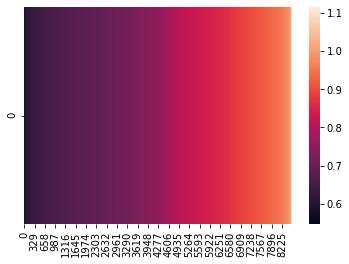

In [ ]:
import seaborn as sns
sns.heatmap(np.array(sorted(costs,reverse=False)).reshape(1,len(costs)))

### Baby Steps Regular Code

(None, 50)
datapoints to be searched from this iteration and trained on 1221 datapoints
datapoints to be searched from this iteration and trained on 2442 datapoints
datapoints to be searched from this iteration and trained on 3663 datapoints
datapoints to be searched from this iteration and trained on 4884 datapoints
datapoints to be searched from this iteration and trained on 6104 datapoints
datapoints to be searched from this iteration and trained on 7324 datapoints
datapoints to be searched from this iteration and trained on 8544 datapoints
0.4570135772228241
(None, 50)
datapoints to be searched from this iteration and trained on 1221 datapoints
datapoints to be searched from this iteration and trained on 2442 datapoints
datapoints to be searched from this iteration and trained on 3663 datapoints
datapoints to be searched from this iteration and trained on 4884 datapoints
datapoints to be searched from this iteration and trained on 6104 datapoints
datapoints to be searched from this

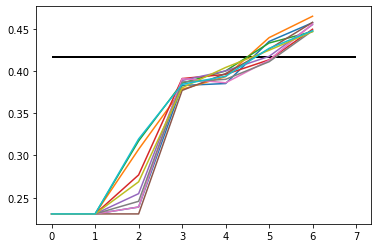

0.4527149349451065 0.4166968375444412


In [ ]:
avg=[]
batch_size=1100#LSTM
batch_size=1400#cnn
batch_size=1100#atLSTM
n=int(len(aux_sorted_indices)/batch_size)
for _ in np.arange(10):
  growth=[]
  newX=[]
  newy=[]
  model1=my_model()
  for batch_ind in np.array_split(aux_sorted_indices,n):
    newX.extend(indexer(X_train,batch_ind))
    newy.extend(indexer(y_train,batch_ind))
    model1=fit_model(np.array(newX),np.array(newy),model1,verbose=0,epochs=30)
    growth.append(model1.evaluate(X_test,y_test,verbose=0)[1])
  plt.plot(growth)
  print(growth[-1])
  avg.append(growth[-1])
  plt.hlines(NC,0, len(growth))
plt.show()
print(np.average(avg),NC)

### Hyper Parameter: Batch_size *Tune*

In [ ]:
results=[]
batch_size_list=[750,800,850,900,950,1000,1500,2000]
batch_size_list=[500,750,800,950,1100,1200,1400,1550,1700]
#batch_size_list=[2000,3000]
for batch_size in batch_size_list:
  print("####################",batch_size,"###############")
  n=int(len(aux_sorted_indices)/batch_size)
  for _ in np.arange(3):
    growth=[]
    newX=[]
    newy=[]
    avg=[]
    model1=my_model()
    for batch_ind in np.array_split(aux_sorted_indices,n):
      newX.extend(indexer(X_train,batch_ind))
      newy.extend(indexer(y_train,batch_ind))
      #print("datapoints to be searched from this iteration and trained on",len(newX),"datapoints")
      model1=fit_model(np.array(newX),np.array(newy),model1,verbose=0,epochs=30)
      growth.append(model1.evaluate(X_test,y_test,verbose=0)[1])
    plt.plot(growth)
    print(growth[-1])
    avg.append(growth[-1])
    plt.hlines(NC,0, len(growth))
  plt.show()
  print(np.average(avg),NC)
  results.append(np.average(avg))

In [ ]:
plt.plot(batch_size_list,results)
plt.hlines(NC,min(batch_size_list), max(batch_size_list))

## Curriculum: Sent Len

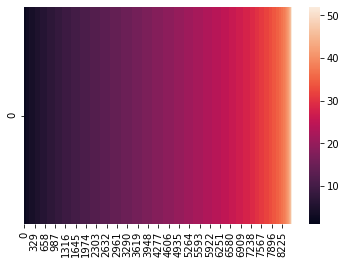

In [ ]:
def length(sentence):
  return len(sentence.split(" "))
scores=[length(i) for i in traindata]
# master order is order of indices
master_order=sorted(range(len(scores)), key=lambda k: scores[k],reverse=True)
import seaborn as sns
sns.heatmap(np.array(sorted(scores,reverse=False)).reshape(1,len(scores)))

### Baby Steps Regular **Code**

In [ ]:
import time
start=time.time()
allindices=list(np.arange(len(X_train)))
multiruns=[]
for rand in np.arange(10):
  model=my_model()
  model.compile(loss="categorical_crossentropy",metrics=["acc"],optimizer="Adam")
  startt=1000
  batch_size=900#lstm
  batch_size=750#cnn
  batch_size=900#alstm
  start_indexes=master_order[:startt]
  newX=np.array(indexer(X_train,start_indexes))
  newy=np.array(indexer(y_train,start_indexes))
  top=startt-1
  ## half starting
  growth=[]
  while top+batch_size<len(X_train):
    print("training on",len(newX),"datapoints")
    model = fit_model(newX,newy,model,epochs=30)
    t=model.evaluate(X_test,y_test)[1]
    print(t,"performance on test data")
    growth.append(t)
    nextindex_list=master_order[top:top+batch_size]###i
    newX=np.concatenate([newX,np.array(indexer(X_train,nextindex_list))])## Baby stepd
    newy=np.append(newy,np.array(indexer(y_train,nextindex_list)),axis=0)
    top=top+batch_size
    print("=======================================")
  multiruns.append(growth)  
end=time.time()
TT=end-start

(None, 50)
training on 1000 datapoints
70/70 [==============================] - 0s 7ms/step - loss: 1.5759 - acc: 0.2389
0.23891402781009674 performance on test data
training on 1900 datapoints
70/70 [==============================] - 0s 7ms/step - loss: 1.4987 - acc: 0.3837
0.38371041417121887 performance on test data
training on 2800 datapoints
70/70 [==============================] - 1s 8ms/step - loss: 1.4234 - acc: 0.3946
0.39457014203071594 performance on test data
training on 3700 datapoints
70/70 [==============================] - 0s 7ms/step - loss: 1.3900 - acc: 0.4127
0.41266968846321106 performance on test data
training on 4600 datapoints
70/70 [==============================] - 0s 7ms/step - loss: 1.3812 - acc: 0.4104
0.41040724515914917 performance on test data
training on 5500 datapoints
70/70 [==============================] - 0s 7ms/step - loss: 1.3242 - acc: 0.4172
0.41719457507133484 performance on test data
training on 6400 datapoints
70/70 [========================

960.0947115421295
0.4588235318660736 0.4166968375444412
960.0947115421295
0.42579185962677 0.4166968375444412
960.0947115421295
0.4339366555213928 0.4166968375444412
960.0947115421295
0.44570136070251465 0.4166968375444412
960.0947115421295
0.4384615421295166 0.4166968375444412
960.0947115421295
0.46244344115257263 0.4166968375444412
960.0947115421295
0.42941176891326904 0.4166968375444412
960.0947115421295
0.43981900811195374 0.4166968375444412
960.0947115421295
0.42941176891326904 0.4166968375444412
960.0947115421295
0.4298642575740814 0.4166968375444412


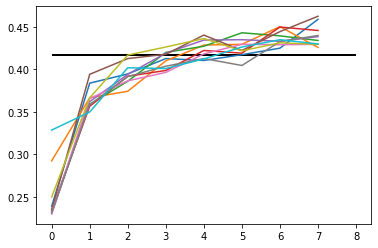

In [ ]:
otemp=multiruns
for growth in otemp:
  print(TT)
  plt.plot(growth)
  plt.hlines(NC,0, len(growth))
  print(growth[-1],NC)#batch size 1, starting 50 , AdjCOunts high easier
  pickle.dump(growth,open("SST_sentlen_900_lstm.pickle","wb"))

### Hyper Parameter: Batch_size Tune

In [ ]:
results=[]
#batch_size_list=[500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000]
#batch_size_list=np.arange(1450,2000,100)
batch_size_list=[500,600,700,800,900,1000,1100,1200,1300]
for batch_size in batch_size_list:
  print("####################",batch_size,"###############")
  randomval=[]
  for rand in np.arange(4):
    model=my_model()
    model.compile(loss="categorical_crossentropy",metrics=["acc"],optimizer="Adam")
    allindices=list(np.arange(len(X_train)))
    startt=1000
    start_indexes=master_order[:startt]
    newX=np.array(indexer(X_train,start_indexes))
    newy=np.array(indexer(y_train,start_indexes))
    top=startt-1
    ## half starting
    #newX=
    growth=[]
    while top+batch_size<len(X_train):
      #print("training on",len(newX),"datapoints")
      model = fit_model(newX,newy,model,epochs=30)
      t=model.evaluate(X_test,y_test,verbose=0)[1]
      #print(t,"performance on test data")
      growth.append(t)
      nextindex_list=master_order[top:top+batch_size]###i
      newX=np.concatenate([newX,np.  array(indexer(X_train,nextindex_list))])
      newy=np.append(newy,np.array(indexer(y_train,nextindex_list)),axis=0)
      top=top+batch_size
    randomval.append(growth[-1])
  results.append(np.average(randomval))

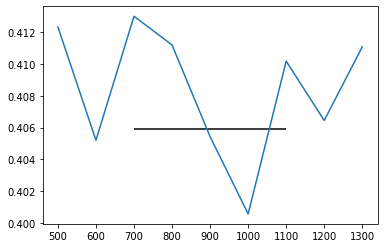

In [ ]:
plt.plot(batch_size_list,results)
plt.hlines(NC,700, 1100)

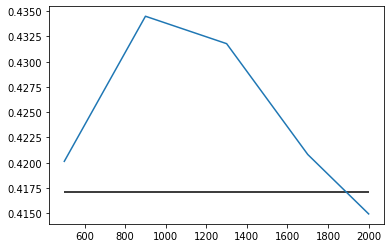

In [ ]:
plt.plot(batch_size_list,results)
plt.hlines(NC,500, 2000)

In [ ]:
plt.plot(batch_size_list,results)
plt.hlines(NC,1300, 1600)